In [1]:
import faiss
import numpy as np


def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')


xb = read_fvecs('sift/sift_base.fvecs')
xq = read_fvecs('sift/sift_query.fvecs')[0].reshape(1, -1)
xq_full = read_fvecs('sift/sift_query.fvecs')

In [2]:
d = 128
M = 32
efSearch = 32
efConstruction = 32

index = faiss.IndexHNSWFlat(d, M)
print(index.hnsw)

<faiss.swigfaiss.HNSW; proxy of <Swig Object of type 'faiss::HNSW *' at 0x000001E0E96AF270> >


In [3]:
index.hnsw.max_level

-1

In [4]:
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

array([], dtype=int64)

In [5]:
index.hnsw.efConstruction = efConstruction
index.hnsw.efSearch = efSearch

In [6]:
index.add(xb)

In [7]:
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

array([     0, 968746,  30276,    951,     26,      1], dtype=int64)

In [8]:
index.hnsw.entry_point

118295

In [9]:
def set_default_probas(M, m_L):
    nn = 0
    cum_nneighbor_per_level = []
    level = 0
    assign_probas = []
    while True:
        proba = np.exp(-level / m_L) * (1 - np.exp(-1 / m_L))
        if proba < 1e-9:
            break
        assign_probas.append(proba)
        nn += M * 2 if level == 0 else M
        cum_nneighbor_per_level.append(nn)
        level += 1
    return assign_probas, cum_nneighbor_per_level

In [10]:
assign_probas, cum_nneighbor_per_level = set_default_probas(
    32, 1 / np.log(32)
)

assign_probas, cum_nneighbor_per_level

([0.96875,
  0.030273437499999986,
  0.0009460449218749991,
  2.956390380859371e-05,
  9.23871994018553e-07,
  2.887099981307982e-08],
 [64, 96, 128, 160, 192, 224])

In [11]:
def random_level(assign_probas, rng):
    f = rng.uniform()
    for level in range(len(assign_probas)):
        if f < assign_probas[level]:
            return level
        f -= assign_probas[level]
    return len(assign_probas) - 1

In [12]:
chosen_levels = []
rng = np.random.default_rng(12345)
for _ in range(1_000_000):
    chosen_levels.append(random_level(assign_probas, rng))
np.bincount(chosen_levels)

array([968821,  30170,    985,     23,      1], dtype=int64)

In [13]:
1 / np.log(32)

0.28853900817779266

In [14]:
set_default_probas(32, 0.09)

([0.9999850546614752, 1.4945115161637832e-05], [64, 96])

In [15]:
del index
index = faiss.IndexHNSWFlat(d, 32)
index.hnsw.set_default_probas(32, 0.09)
index.hnsw.efConstruction = efConstruction
index.add(xb)

In [16]:
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

array([     0, 968746,  30276,    951,     26,      1], dtype=int64)

In [17]:
assign_probas, cum_nneighbor_per_level = set_default_probas(32, 0.0000001)
assign_probas, cum_nneighbor_per_level

([1.0], [64])

In [18]:
from tqdm import tqdm
chosen_levels = []
rng = np.random.default_rng(12345)
for _ in tqdm(range(1_000_000)):
    chosen_levels.append(random_level(assign_probas, rng))

100%|██████████| 1000000/1000000 [00:03<00:00, 267168.98it/s]


In [19]:
np.bincount(chosen_levels)

array([1000000], dtype=int64)

In [20]:
del index
index = faiss.IndexHNSWFlat(d, 32)
index.hnsw.efConstruction = efConstruction
index.add(xb[:1_000])

In [21]:
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

array([  0, 974,  25,   1], dtype=int64)

#### Testing Faiss Parameters

In [22]:
recall_idx = []

index = faiss.IndexFlatL2(d)
index.add(xb)
D, recall_idx = index.search(xq_full[:1000], k=1)

In [23]:
import os
def get_memory(index):
    faiss.write_index(index, './temp.index')
    file_size = os.path.getsize('./temp.index')
    os.remove('./temp.index')
    return file_size

In [24]:
import pandas as pd
from tqdm.auto import trange
from datetime import datetime
import warnings 
warnings.filterwarnings('ignore')

results = pd.DataFrame({
    'M': [],
    'efConstruction': [],
    'efSearch': [],
    'recall@1': [],
    'build_time': [],
    'search_time': [],
    'memory_usage': []
})

for epoch in range(3):
    for M_bit in range(1, 8):
        M = 2 ** M_bit
        print(M)
        for ef_bit in trange(1, 6):
            efConstruction = 2 ** ef_bit
            index = faiss.IndexHNSWFlat(d, M)
            index.efConstruction = efConstruction
            start = datetime.now()
            index.add(xb)
            build_time = (datetime.now() - start).microseconds
            memory_usage = get_memory(index)
            for efSearch in [2, 4, 8, 16, 32]:
                index.efSearch = efSearch
                start = datetime.now()
                D, I = index.search(xq_full[:1000], k=1)
                search_time = (datetime.now() - start).microseconds
                recall = sum(I == recall_idx)[0]
                results = results.append({
                    'M': M,
                    'efConstruction': efConstruction,
                    'efSearch': efSearch,
                    'recall@1': recall,
                    'build_time': build_time,
                    'search_time': search_time,
                    'memory_usage': memory_usage
                }, ignore_index=True)
            del index

2


  0%|          | 0/5 [00:00<?, ?it/s]

4


  0%|          | 0/5 [00:00<?, ?it/s]

8


  0%|          | 0/5 [00:00<?, ?it/s]

16


  0%|          | 0/5 [00:00<?, ?it/s]

32


  0%|          | 0/5 [00:00<?, ?it/s]

64


  0%|          | 0/5 [00:00<?, ?it/s]

128


  0%|          | 0/5 [00:00<?, ?it/s]

2


  0%|          | 0/5 [00:00<?, ?it/s]

4


  0%|          | 0/5 [00:00<?, ?it/s]

8


  0%|          | 0/5 [00:00<?, ?it/s]

16


  0%|          | 0/5 [00:00<?, ?it/s]

32


  0%|          | 0/5 [00:00<?, ?it/s]

64


  0%|          | 0/5 [00:00<?, ?it/s]

128


  0%|          | 0/5 [00:00<?, ?it/s]

2


  0%|          | 0/5 [00:00<?, ?it/s]

4


  0%|          | 0/5 [00:00<?, ?it/s]

8


  0%|          | 0/5 [00:00<?, ?it/s]

16


  0%|          | 0/5 [00:00<?, ?it/s]

32


  0%|          | 0/5 [00:00<?, ?it/s]

64


  0%|          | 0/5 [00:00<?, ?it/s]

128


  0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
results.to_csv('./results.csv', sep='|', index=False)

In [26]:
results = pd.read_csv('./results.csv', sep='|')
results.head()

,M,efConstruction,efSearch,recall@1,build_time,search_time,memory_usage
0,2.0,2.0,2.0,128.0,813789.0,14961.0,547995894.0
1,2.0,2.0,4.0,128.0,813789.0,9974.0,547995894.0
2,2.0,2.0,8.0,128.0,813789.0,10970.0,547995894.0
3,2.0,2.0,16.0,128.0,813789.0,9974.0,547995894.0
4,2.0,2.0,32.0,128.0,813789.0,10971.0,547995894.0


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

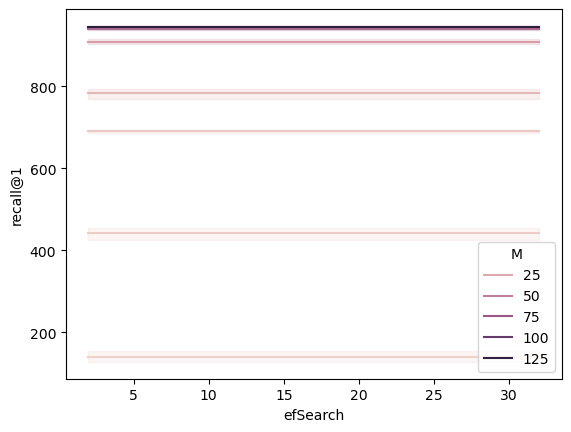

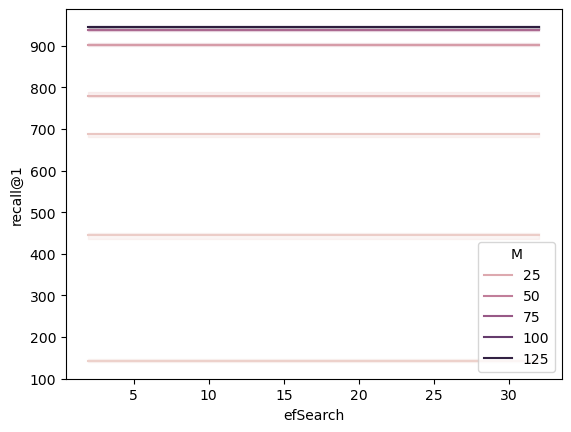

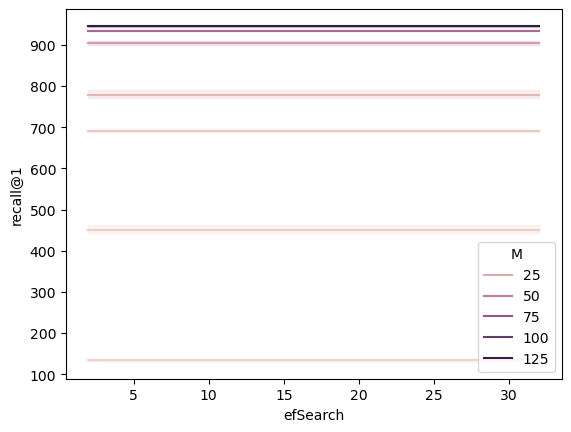

In [28]:
for efConstruction in [2, 8, 32]:
    sns.lineplot(data=results[results['efConstruction'] == efConstruction], x='efSearch', y='recall@1', hue='M')
    plt.show()

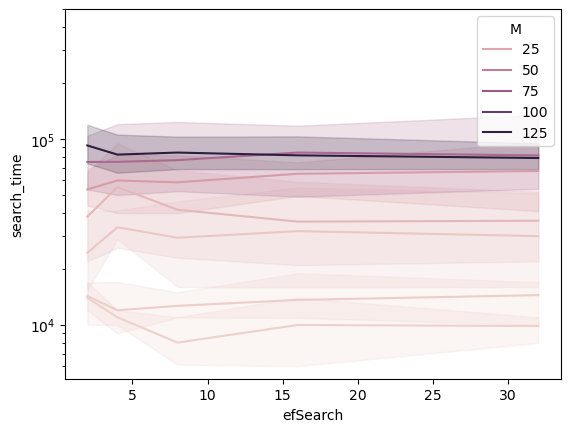

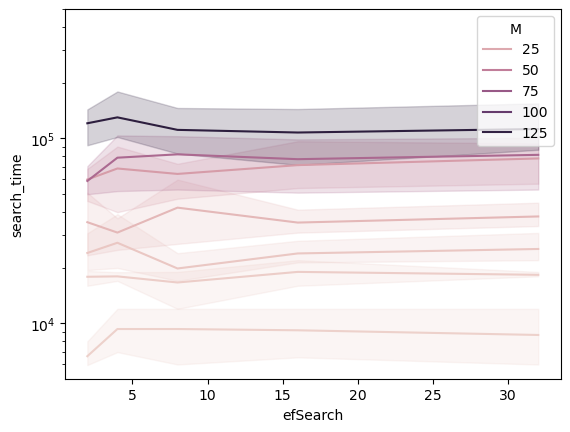

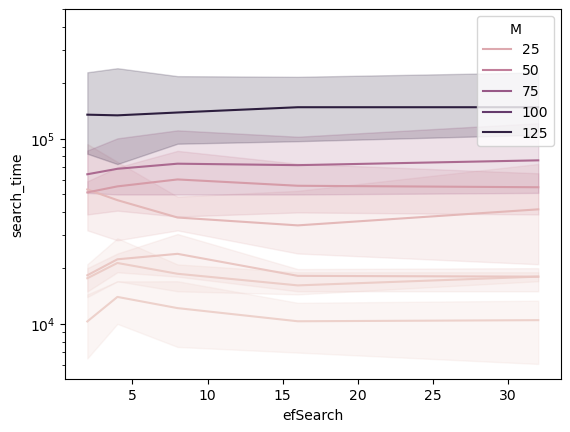

In [29]:
for efConstruction in [2, 8, 32]:
    sns.lineplot(data=results[results['efConstruction'] == efConstruction], x='efSearch', y='search_time', hue='M')
    plt.yscale('log')
    plt.ylim(0, 500_000)
    plt.show()

<Axes: xlabel='M', ylabel='memory_usage'>

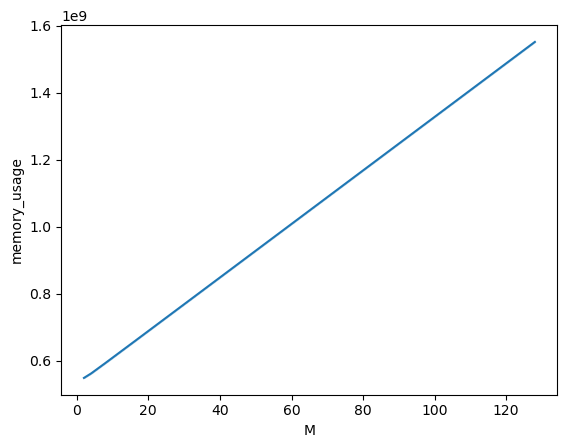

In [30]:
sns.lineplot(data=results, x='M', y='memory_usage')